In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, dot, SimpleRNN, Attention
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2023-06-14 12:34:56.129418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load and preprocess the data
df = pd.read_csv('../Datasets/INTC Historical Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# Extract the 'Close' price column for prediction
data = df[['Price']]

In [3]:
# 4. Chia train test
train_size = int(0.6 * len(data))
test_size = int(0.3 * len(data))
val_size = len(data) - train_size - test_size

train = data[:train_size]
test = data[train_size:train_size+test_size]
val = data[train_size+test_size:]

print(f"train shape: {train.shape}")
print(f"val shape: {val.shape}")
print(f"test shape: {test.shape}")

train shape: (966, 1)
val shape: (162, 1)
test shape: (483, 1)


In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(train)
val_data = scaler.transform(val)
test_data = scaler.transform(test)

print(f"train_data shape: {train_data.shape}")
print(f"val_data shape: {val_data.shape}")
print(f"test_data shape: {test_data.shape}")

train_data shape: (966, 1)
val_data shape: (162, 1)
test_data shape: (483, 1)


In [5]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [6]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((865, 100, 1), (865,), (382, 100, 1), (382,), (61, 100, 1), (61,))

In [8]:
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [ ]:
def attention_rnn(input_shape, units):
  input_layer = tf.keras.Input(shape=input_shape)
  lstm_output = SimpleRNN(units)(input_layer)
  attention = Attention()([lstm_output, lstm_output])
  output = Dense(1)(attention)
  model = Model(inputs=input_layer, outputs=output)
  return model

In [10]:
# 8. Define RNN Model Attetion

model = attention_rnn(input_shape=(time_step,1), units=50)
# model.summary()

# Neu nhu phat hien overfitting,sau 3 epoch, val_loss ko co cai thien se dung train
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mean_absolute_error'])

In [13]:
# 9. Fit mô hình với dữ liệu train
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100,batch_size=64,verbose=1, callbacks=[callback])

Epoch 1/100
14/14 [==============================] - 1s 41ms/step - loss: 0.0069 - mean_absolute_error: 0.0632 - val_loss: 0.0515 - val_mean_absolute_error: 0.2218
Epoch 2/100
14/14 [==============================] - 0s 29ms/step - loss: 0.0066 - mean_absolute_error: 0.0618 - val_loss: 0.0618 - val_mean_absolute_error: 0.2437
Epoch 3/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0074 - mean_absolute_error: 0.0655 - val_loss: 0.0581 - val_mean_absolute_error: 0.2362
Epoch 4/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0072 - mean_absolute_error: 0.0648 - val_loss: 0.0587 - val_mean_absolute_error: 0.2375
Epoch 5/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0076 - mean_absolute_error: 0.0673 - val_loss: 0.0602 - val_mean_absolute_error: 0.2405
Epoch 6/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0066 - mean_absolute_error: 0.0616 - val_loss: 0.0589 - val_mean_absolute_error: 0.2378


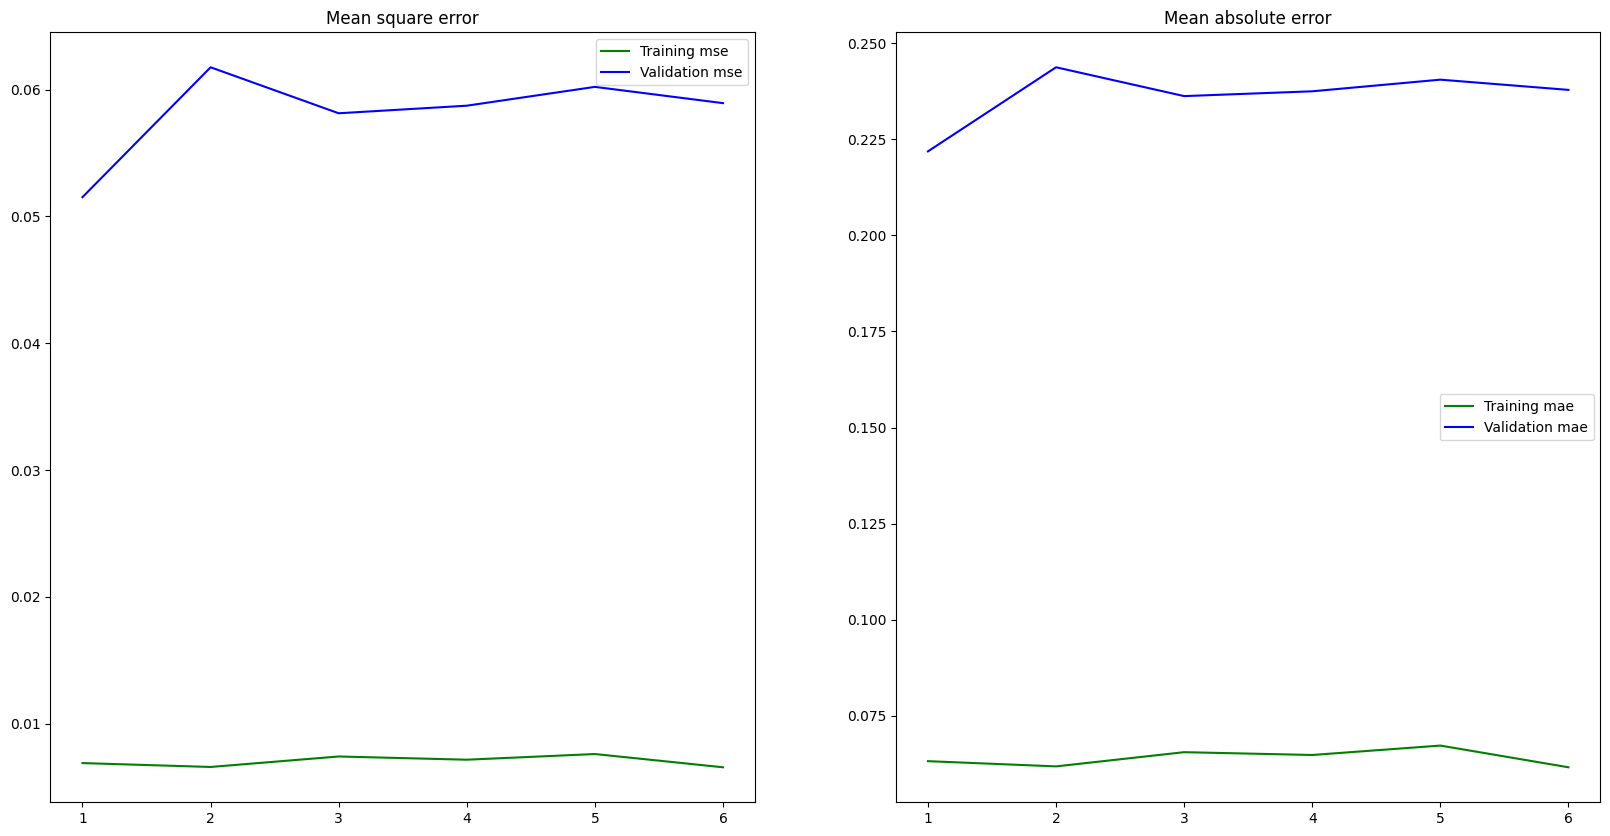

In [14]:
mae_train = history.history['mean_absolute_error']
mae_val = history.history['val_mean_absolute_error']

mse_train = history.history['loss']
mse_val = history.history['val_loss']

epochs = range(1, len(mae_train) + 1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(epochs, mse_train, 'g', label='Training mse')
plt.plot(epochs, mse_val, 'b', label='Validation mse')
plt.title('Mean square error')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, mae_train, 'g', label='Training mae')
plt.plot(epochs, mae_val, 'b', label='Validation mae')
plt.title('Mean absolute error')
plt.legend()

plt.show()

In [16]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

2/2 [==============================] - 0s 4ms/step
Validation RMSE: 38.24912119200009
Testing RMSE: 47.87228383137755


In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[61:].reshape(1,-1)
print(f"x_input shape: {x_input.shape}")

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(f"temp_input shape: {len(temp_input)}")

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


x_input shape: (1, 101)
temp_input shape: 101
0 day input [-0.16509569 -0.16852328 -0.13510426 -0.11853756 -0.11482434 -0.1031134
 -0.09054556 -0.09568695 -0.11025421 -0.13281919 -0.14395887 -0.12110825
 -0.09111682 -0.10111397 -0.10739789 -0.09625821 -0.15138532 -0.1573836
 -0.14852899 -0.12539274 -0.09340189 -0.08968866 -0.13624679 -0.12596401
 -0.14910026 -0.16366752 -0.16166809 -0.14024564 -0.13767495 -0.13167666
 -0.15024279 -0.16709512 -0.21136818 -0.22822051 -0.22422165 -0.23764639
 -0.24450157 -0.24364467 -0.23221937 -0.20736932 -0.20165667 -0.21336761
 -0.22650671 -0.21365324 -0.20051414 -0.17823479 -0.18594687 -0.15566981
 -0.1442445  -0.09368752 -0.10425593 -0.12282205 -0.14281634 -0.15224222
 -0.12653528 -0.1171094  -0.12225079 -0.11910883 -0.05541274 -0.03913168
 -0.02256498 -0.01628106 -0.01028278 -0.01799486 -0.01856612 -0.02684947
 -0.03170523 -0.04113111 -0.03798915 -0.04484433 -0.03770351 -0.04655813
 -0.06598115 -0.0742645  -0.09025993 -0.10854042 -0.13081977 -0.1259

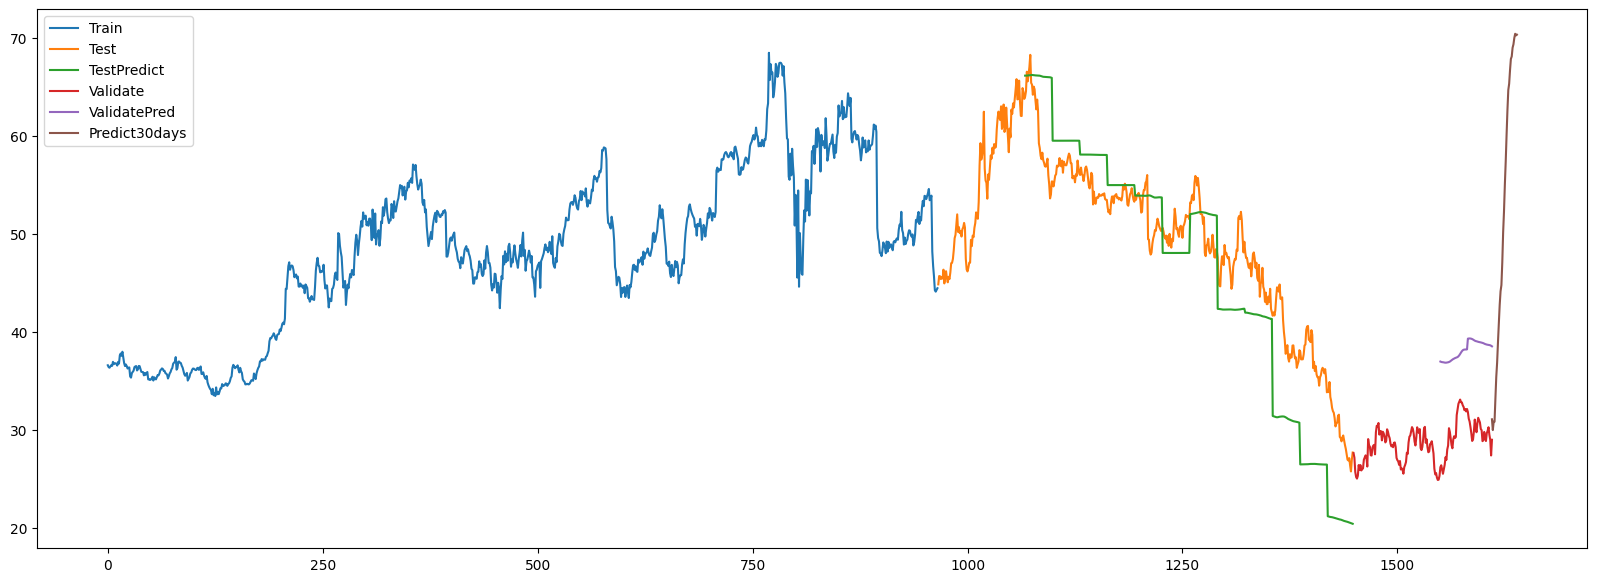

In [18]:
# 14.Vẽ hình
plt.figure(figsize=(20,7))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

predict_data_index = pd.RangeIndex(start=len(data)-1, stop=len(data)+29, step=1)

plt.plot(predict_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','TestPredict','Validate','ValidatePred','Predict30days'])
plt.show()